In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import ast

from pymatgen.io.cif import CifParser
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.analysis.local_env import CrystalNN

from io import StringIO
import multiprocessing
from tqdm import tqdm

import matplotlib.pyplot as plt

In [3]:
#load in train.pt
train_graphs = torch.load('data/train.pt')

In [4]:
all_graph_keys = list(train_graphs.keys())

In [5]:
import numpy as np

MAX_ATOM = 80 

def connectivity_pairs(train_graphs):
    all_bonded_atoms = []
    for index in tqdm(range(len(train_graphs))):
        key = all_graph_keys[index]
        # Extracting edge and node information from the graph object
        node_positions, atomic_numbers, lengths, angles, edges, indices, index = train_graphs[key]

        # Creating a dictionary to map node indices to atomic numbers
        node_atomic_numbers = {idx: atomic_number for idx, atomic_number in enumerate(atomic_numbers)}

        # Extracting atomic numbers bonded together from the edge information
        bonded_atomic_numbers = []
        for edge in edges:
            node_idx1, node_idx2 = edge
            atomic_number1 = node_atomic_numbers[node_idx1]
            atomic_number2 = node_atomic_numbers[node_idx2]
            bonded_atomic_numbers.append((atomic_number1, atomic_number2))

        bonded_atoms = []
        for bonded_pair in bonded_atomic_numbers:
            if list(bonded_pair) not in bonded_atoms and [bonded_pair[1], bonded_pair[0]]  not in bonded_atoms and (bonded_pair[1] < MAX_ATOM and bonded_pair[0] < MAX_ATOM): 
                bonded_atoms.append(list(bonded_pair))

        all_bonded_atoms.append(bonded_atoms)
    
    #flatten all_bonded_atoms 
    all_bonded_atoms_flat = []
    for sublist in all_bonded_atoms:
        all_bonded_atoms_flat += sublist
    return all_bonded_atoms_flat

def co_occupancy_pairs(train_df):
    train_df['atomic_numbers'] = train_df['atomic_numbers'].apply(ast.literal_eval)
    elemental_corpus = train_df['atomic_numbers'].tolist()

    #subtract 1 from every entry in the list
    elemental_corpus = [[x-1 for x in sublist] for sublist in elemental_corpus]

    #now, we want to create a list of all pairs of atoms that appear in a compound together 
    list_of_pairs = []
    from tqdm import tqdm 
    for compound in tqdm(elemental_corpus):
        for i in range(len(compound)):
            for j in range(i+1, len(compound)):
                if compound[j] != compound[i] and (compound[i], compound[j]) not in list_of_pairs:
                    list_of_pairs.append((compound[i], compound[j]))
    return list_of_pairs

In [6]:
list_of_pairs = connectivity_pairs(train_graphs)

  0%|          | 0/36183 [00:00<?, ?it/s]

100%|██████████| 36183/36183 [00:03<00:00, 10406.72it/s]


In [12]:
training_data = np.stack([np.array(x) for x in list_of_pairs])

NameError: name 'list_of_pairs' is not defined

In [13]:
training_data_onehot = torch.nn.functional.one_hot(torch.tensor(training_data), num_classes=MAX_ATOM)

TypeError: new(): invalid data type 'str'

In [9]:
training_data_onehot.shape

torch.Size([97853, 2, 80])

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    def __init__(self, onehot, original):
        self.data_tensor = onehot
        self.original = original

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        input_data = self.data_tensor[idx, 0, :]  # input data
        target_data = self.original[idx, 1]  # target data
        return input_data.float(), target_data.long()

# Create dataset instance
word2vec_dataset = Word2VecDataset(training_data_onehot, torch.tensor(training_data))

NameError: name 'training_data_onehot' is not defined

In [ ]:
# Create DataLoader
batch_size = 32  # Adjust batch size as needed
word2vec_dataloader = DataLoader(word2vec_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
class elem2vec(nn.Module):
    def __init__(self, numelem, hidden_dim):
        super(elem2vec, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(numelem, hidden_dim, bias=False),
            nn.Linear(hidden_dim, numelem, bias=False),
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
numelem = MAX_ATOM  
model = elem2vec(numelem, hidden_dim = 40)
max_epochs = 20
# Define optimizer and loss function
weight_decay = 0  # Example value, adjust based on your needs
optimizer = optim.Adam(model.parameters(), lr=0.02, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [ ]:
model = model.to('cuda')

In [ ]:
for epoch in tqdm(range(max_epochs)):
    model.train()  # Set the model to training mode

    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for center, context in word2vec_dataloader:
        center = center.to('cuda')
        context = context.to('cuda')
        optimizer.zero_grad()

        pred = model(center)
        loss = criterion(pred, context)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        _, predicted = torch.max(pred.data, 1)
        total_train += context.size(0)
        correct_train += (predicted == context).sum().item()

    train_accuracy = 100 * correct_train / total_train
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{max_epochs} - Loss: {total_train_loss:.4f} - Accuracy: {train_accuracy:.2f}%")

  5%|▌         | 1/20 [00:05<01:42,  5.38s/it]

Epoch 1/20 - Loss: 10510.6074 - Accuracy: 21.86%


 10%|█         | 2/20 [00:08<01:11,  3.95s/it]

Epoch 2/20 - Loss: 10384.4969 - Accuracy: 22.35%


 15%|█▌        | 3/20 [00:11<00:59,  3.52s/it]

Epoch 3/20 - Loss: 10359.2273 - Accuracy: 22.25%


 20%|██        | 4/20 [00:14<00:52,  3.27s/it]

Epoch 4/20 - Loss: 10348.9039 - Accuracy: 22.39%


 25%|██▌       | 5/20 [00:17<00:47,  3.14s/it]

Epoch 5/20 - Loss: 10337.3852 - Accuracy: 22.42%


 30%|███       | 6/20 [00:20<00:42,  3.05s/it]

Epoch 6/20 - Loss: 10341.4231 - Accuracy: 22.35%


 35%|███▌      | 7/20 [00:22<00:38,  3.00s/it]

Epoch 7/20 - Loss: 10329.9843 - Accuracy: 22.36%


 40%|████      | 8/20 [00:25<00:35,  2.96s/it]

Epoch 8/20 - Loss: 10328.6468 - Accuracy: 22.47%


 45%|████▌     | 9/20 [00:28<00:32,  2.94s/it]

Epoch 9/20 - Loss: 10325.6608 - Accuracy: 22.40%


 50%|█████     | 10/20 [00:31<00:29,  2.92s/it]

Epoch 10/20 - Loss: 10326.7691 - Accuracy: 22.38%


 55%|█████▌    | 11/20 [00:34<00:26,  2.91s/it]

Epoch 11/20 - Loss: 10321.8553 - Accuracy: 22.53%


 60%|██████    | 12/20 [00:37<00:23,  2.90s/it]

Epoch 12/20 - Loss: 10322.3244 - Accuracy: 22.49%


 65%|██████▌   | 13/20 [00:40<00:20,  2.90s/it]

Epoch 13/20 - Loss: 10319.7609 - Accuracy: 22.50%


 70%|███████   | 14/20 [00:43<00:17,  2.89s/it]

Epoch 14/20 - Loss: 10318.0427 - Accuracy: 22.47%


 75%|███████▌  | 15/20 [00:45<00:14,  2.89s/it]

Epoch 15/20 - Loss: 10328.0656 - Accuracy: 22.49%


 80%|████████  | 16/20 [00:48<00:11,  2.88s/it]

Epoch 16/20 - Loss: 10324.9368 - Accuracy: 22.53%


 85%|████████▌ | 17/20 [00:51<00:08,  2.89s/it]

Epoch 17/20 - Loss: 10324.1949 - Accuracy: 22.49%


 90%|█████████ | 18/20 [00:54<00:05,  2.89s/it]

Epoch 18/20 - Loss: 10321.5227 - Accuracy: 22.62%


 95%|█████████▌| 19/20 [00:57<00:02,  2.89s/it]

Epoch 19/20 - Loss: 10314.9810 - Accuracy: 22.61%


100%|██████████| 20/20 [01:00<00:00,  3.02s/it]

Epoch 20/20 - Loss: 10322.1472 - Accuracy: 22.50%


In [25]:
params_list = []
indx = 0
for param in model.parameters():
    params_list.append(param)
    torch.save(param, f"param_{indx}.pt")
    print(param.size())
    indx += 1

torch.Size([40, 80])
torch.Size([80, 40])


: 

In [7]:
#load in the parameters
params_list = []
indx = 0
for indx in range(2):
    param = torch.load(f"param_{indx}.pt", map_location=torch.device('cpu'))
    params_list.append(param)
    print(param.size())
    indx += 1

elem2vec = params_list[1]

torch.Size([40, 80])
torch.Size([80, 40])


In [8]:
from pymatgen.core.periodic_table import Element

# List of atomic numbers
atomic_numbers = list(range(1, MAX_ATOM))

# Dictionary to store atomic radii
atomic_radii = []

# Iterate over the atomic numbers and retrieve atomic radii
for atomic_number in atomic_numbers:
    element = Element.from_Z(atomic_number)
    atomic_radius = element.atomic_radius
    atomic_radii.append(atomic_radius)

#replace None entries with 0 
atomic_radii = [elem if elem != None else 0 for elem in atomic_radii ]

atomic_radii = np.array(atomic_radii)

from pymatgen.core.periodic_table import Element

# Get a list of all element symbols
element_symbols = [elem.symbol for elem in Element]

In [11]:
#get the embedding for sodium 
atomic_number = 27
index = atomic_number - 1
sodium = params_list[1][index]

#find the closest element to sodium by cosine similarity
import torch.nn.functional as F
cosine_sim = torch.exp(F.cosine_similarity(sodium.unsqueeze(0), params_list[1], dim=1)) / max(torch.exp(F.cosine_similarity(sodium.unsqueeze(0), params_list[1], dim=1)))

In [12]:
# Convert tensor to list
tensor_list = cosine_sim.tolist()
# Convert list to DataFrame
df = pd.DataFrame({'Values': tensor_list, 'Elements': element_symbols[0:MAX_ATOM]})
# Sort DataFrame by 'Values' column from max to min
df_sorted = df.sort_values(by='Values', ascending=False)

print(df_sorted[0:10])

      Values Elements
26  1.000000       Co
27  0.637838       Ni
23  0.611752       Cr
24  0.591928       Mn
73  0.589748        W
25  0.567367       Fe
41  0.553889       Mo
42  0.520777       Tc
5   0.514877        C
22  0.511896        V


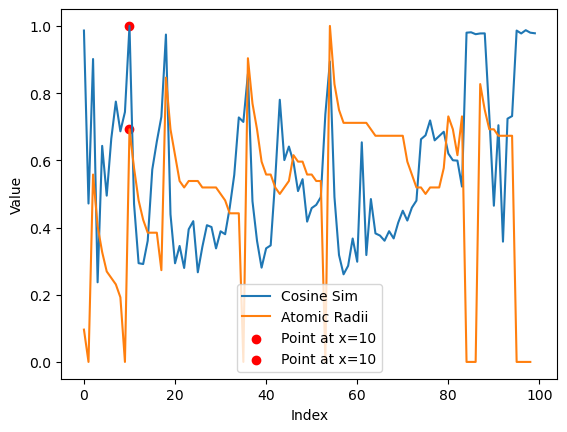

In [ ]:

# Plot the first curve
plt.plot(cosine_sim.detach().cpu().numpy(), label='Cosine Sim')

# Plot the second curve
plt.plot(atomic_radii / max(atomic_radii), label='Atomic Radii')

# Plot a red dot at x = 10
plt.scatter(index, cosine_sim.detach().cpu().numpy()[index], color='red', label='Point at x=10')
plt.scatter(index, (atomic_radii / max(atomic_radii))[index], color='red', label='Point at x=10')

# Set labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()
